# Plot 3 — Feature Map Visualization

**Plot:** Image grid of feature maps from a selected pretrained model layer

**Concepts:** Images as tensors, local receptive fields, hierarchical feature extraction

---

## What question does this plot answer?
**How does a pretrained model transform an input image into a set of intermediate feature maps, and how do those feature maps differ across pretrained models?**

## Why is it important?
Feature maps provide a *window into what the network is “looking for”* at different depths (edges/textures early, more complex patterns later). Visualizing them helps debug models and build intuition for how convolution and nonlinearity produces progressively richer representations.

---

### Student Submission Template
**Title:**  
**What question does this plot answer?**  

**Description (1–2 sentences):**  
**What data / model / comparison is shown?**  


## 0. Setup

This notebook:
1. Creates (or loads) one input image.
2. Runs it through a pretrained model.
3. Captures the activation tensor from **one layer**.
4. Plots a grid of **feature maps**.

> Notes:
> - By default we use `torchvision`'s **ResNet-18**. It will try to load pretrained weights (may download on first run).
> - If pretrained weights cannot be loaded (e.g., no internet), it will fall back to a randomly initialized model (still demonstrates shapes + local receptive fields).


In [1]:
# If running on Colab / a fresh env, you may need:
# !pip install torch torchvision --quiet

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


torch: 2.10.0
torchvision: 0.25.0
device: cpu


## 1. Input image (as a tensor)

You have two options:
- **Option A (default):** Generate a simple synthetic image (shapes + text) so the plot is self-contained.
- **Option B:** Load your own image by setting `IMAGE_PATH`.

We then:
- Convert it to a tensor of shape **[C, H, W]**
- Add a batch dimension → **[1, C, H, W]**


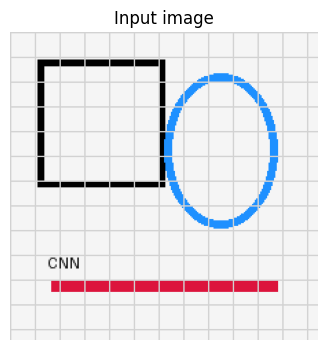

x.shape: (1, 3, 224, 224)


In [3]:
IMAGE_PATH = None  # e.g., "my_image.jpg" or "data/cat.png"

def make_synthetic_image(size=224):
    img = Image.new("RGB", (size, size), (245, 245, 245))
    d = ImageDraw.Draw(img)

    # Basic shapes (edges, corners, textures)
    d.rectangle([20, 20, size//2, size//2], outline=(0, 0, 0), width=5)
    d.ellipse([size//2, 30, size-30, size//2+30], outline=(30, 144, 255), width=6)
    d.line([30, size-40, size-30, size-40], fill=(220, 20, 60), width=8)

    # A simple grid texture
    step = 18
    for x in range(0, size, step):
        d.line([x, 0, x, size], fill=(210, 210, 210), width=1)
    for y in range(0, size, step):
        d.line([0, y, size, y], fill=(210, 210, 210), width=1)

    # Add text (if font unavailable, PIL falls back gracefully)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 32)
    except Exception:
        font = None
    d.text((28, size//2 + 50), "CNN", fill=(0, 0, 0), font=font)
    return img

if IMAGE_PATH is None:
    pil_img = make_synthetic_image(224)
else:
    pil_img = Image.open(IMAGE_PATH).convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(pil_img)
plt.axis("off")
plt.title("Input image")
plt.show()

# Convert to tensor for CNN
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),  # [C,H,W], float in [0,1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

x = preprocess(pil_img).unsqueeze(0).to(device)  # [1,C,H,W]
print("x.shape:", tuple(x.shape))


## 2. Choose a pretrained model + pick a layer to visualize

We will work with an example:
- Load **ResNet-18**
- Register a *forward hook* on the chosen convolutional layer to capture its activations


### Student section: load **your own** pretrained model

By default, this notebook uses **ResNet-18** from `torchvision`.  

For this assignment, you want to visualize feature maps from another pretrained model, e.g., **ViT** and **DINO** by implementing `load_custom_model()` below.

Requirements:
- Return a `torch.nn.Module`
- Move it to `device` and set `model.eval()`
- Make sure the input preprocessing (size / normalization) matches how your model was trained

Tip: after loading, run `dict(model.named_modules()).keys()` to find the layer name to hook.


In [4]:
# If you set MODEL_SOURCE = "custom" later, this function will be used.
# Replace the body with your own loading logic.

def load_custom_model(checkpoint_path: str, device: torch.device) -> torch.nn.Module:
    """Load *your* pretrained model for feature-map visualization.

    Args:
        checkpoint_path: path to a saved checkpoint (e.g., .pt / .pth)
        device: torch device to move the model to

    Returns:
        model: a torch.nn.Module in eval mode on the requested device
    """
    # ============================
    # STUDENT TODO: custom model loader
    # ============================

In [26]:
# ============================
# STUDENT EDITABLE PARAMETERS
# ============================

MODEL_SOURCE = "resnet18"        # "resnet18" (default) or "custom"
CUSTOM_CHECKPOINT_PATH = None

LAYER_NAME = "conv1"
NUM_FEATURE_MAPS = 32          # how many channels to visualize
N_COLS = 8                     # grid columns
USE_PRETRAINED = True          # set False if you want random init on purpose

# ============================
# Load model
# ============================
def load_resnet18(use_pretrained=True):
    try:
        if use_pretrained:
            # Newer torchvision uses "weights="
            weights = torchvision.models.ResNet18_Weights.DEFAULT
            model = torchvision.models.resnet18(weights=weights)
        else:
            model = torchvision.models.resnet18(weights=None)
        return model
    except Exception as e:
        print("⚠️ Could not load pretrained weights (falling back to random init).")
        print("Reason:", repr(e))
        model = torchvision.models.resnet18(weights=None)
        return model

if MODEL_SOURCE == "resnet18":
    model = load_resnet18(USE_PRETRAINED).to(device)
elif MODEL_SOURCE == "custom":
    model = load_custom_model(CUSTOM_CHECKPOINT_PATH, device).to(device)
else:
    raise ValueError(f"Unknown MODEL_SOURCE: {MODEL_SOURCE!r}. Use 'resnet18' or 'custom'.")

model.eval()

# Build a name->module dict for easy lookup
module_dict = dict(model.named_modules())

# Helpful: list some layers
suggestions = [k for k, v in module_dict.items() if isinstance(v, nn.Conv2d)]
print(f"Found {len(suggestions)} Conv2d layers.")

print("Example layer names:")
for name in suggestions:
    if name in module_dict:
        print("  ✓", name)
    else:
        print("  ✗", name, "(not found)")

assert LAYER_NAME in module_dict, f"Layer '{LAYER_NAME}' not found. Try one of the printed examples."


# What kind of activation do you expect from the hooked layer?
# - "cnn": typical conv feature maps, shape [B, C, H, W]
# - "vit": token embeddings, typically shape [B, N, D] (N = #tokens, D = embedding dim)
# If you're using DINOv2 / ViT, set this to "vit" and choose an appropriate LAYER_NAME.
MODEL_OUTPUT_KIND = "cnn"      # "cnn" or "vit"

# ViT/DINO visualization options (used only when MODEL_OUTPUT_KIND == "vit")
VIT_HAS_CLS_TOKEN = True       # True for most ViT/DINO models; set False if your model outputs patch tokens only
VIT_TOKEN_GRID = None          # (H, W) in patch-token grid; leave None to infer as sqrt(N or N-1)
VIT_NUM_DIMS = 16              # how many embedding dimensions to visualize as "feature maps" (dim-slices)
VIT_DIM_INDICES = None         # e.g., [0, 1, 2, 10, 50]; if None, uses first VIT_NUM_DIMS dims

# Alternative: visualize token L2 norm map instead of dim-slices
VIT_SHOW_TOKEN_NORM_MAP = True

Found 20 Conv2d layers.
Example layer names:
  ✓ conv1
  ✓ layer1.0.conv1
  ✓ layer1.0.conv2
  ✓ layer1.1.conv1
  ✓ layer1.1.conv2
  ✓ layer2.0.conv1
  ✓ layer2.0.conv2
  ✓ layer2.0.downsample.0
  ✓ layer2.1.conv1
  ✓ layer2.1.conv2
  ✓ layer3.0.conv1
  ✓ layer3.0.conv2
  ✓ layer3.0.downsample.0
  ✓ layer3.1.conv1
  ✓ layer3.1.conv2
  ✓ layer4.0.conv1
  ✓ layer4.0.conv2
  ✓ layer4.0.downsample.0
  ✓ layer4.1.conv1
  ✓ layer4.1.conv2


## 3. Extract feature maps from the chosen layer

The activation tensor for a convolutional layer has shape:
- **[B, C, H, W]**
where:
- **B** batch size
- **C** number of feature maps (channels)
- **H, W** spatial resolution


In [27]:
# -------------------------
# Capture intermediate activations from a chosen layer
# -------------------------

# NOTE: You can set LAYER_NAME above to any entry in:
#   dict(model.named_modules()).keys()

activations = {}

def _detach_to_cpu(obj):
    if torch.is_tensor(obj):
        return obj.detach().cpu()
    if isinstance(obj, (list, tuple)):
        return type(obj)(_detach_to_cpu(x) for x in obj)
    if isinstance(obj, dict):
        return {k: _detach_to_cpu(v) for k, v in obj.items()}
    return obj

def hook_fn(module, inp, out):
    # out can be:
    #  - CNN: [B, C, H, W]
    #  - ViT: [B, N, D]
    #  - tuple/list: (tokens, ...) depending on implementation
    activations["raw"] = _detach_to_cpu(out)

if LAYER_NAME not in module_dict:
    raise KeyError(f"LAYER_NAME='{LAYER_NAME}' not found in model.named_modules(). "
                   f"Tip: print(sorted(module_dict.keys())[:50]) to inspect names.")

handle = module_dict[LAYER_NAME].register_forward_hook(hook_fn)

with torch.no_grad():
    _ = model(x)

handle.remove()

raw = activations["raw"]

# Heuristic: pick the first tensor if the hook returned a tuple/list
feat = None
if torch.is_tensor(raw):
    feat = raw
elif isinstance(raw, (list, tuple)):
    for item in raw:
        if torch.is_tensor(item):
            feat = item
            break
elif isinstance(raw, dict):
    for _, item in raw.items():
        if torch.is_tensor(item):
            feat = item
            break

if feat is None:
    raise ValueError("Hook output did not contain a Tensor. Got type: " + str(type(raw)))

print("Captured activations from:", LAYER_NAME)
print("feat.shape:", tuple(feat.shape))
print("MODEL_OUTPUT_KIND:", MODEL_OUTPUT_KIND)


Captured activations from: conv1
feat.shape: (1, 64, 112, 112)
MODEL_OUTPUT_KIND: cnn


## 4. Plot: a grid of feature maps

We take the first image in the batch (B=1) and visualize the first `NUM_FEATURE_MAPS` channels.

Implementation details:
- Each feature map is normalized to `[0, 1]` for display.
- You can change `NUM_FEATURE_MAPS` and `LAYER_NAME` to compare early vs late layers.


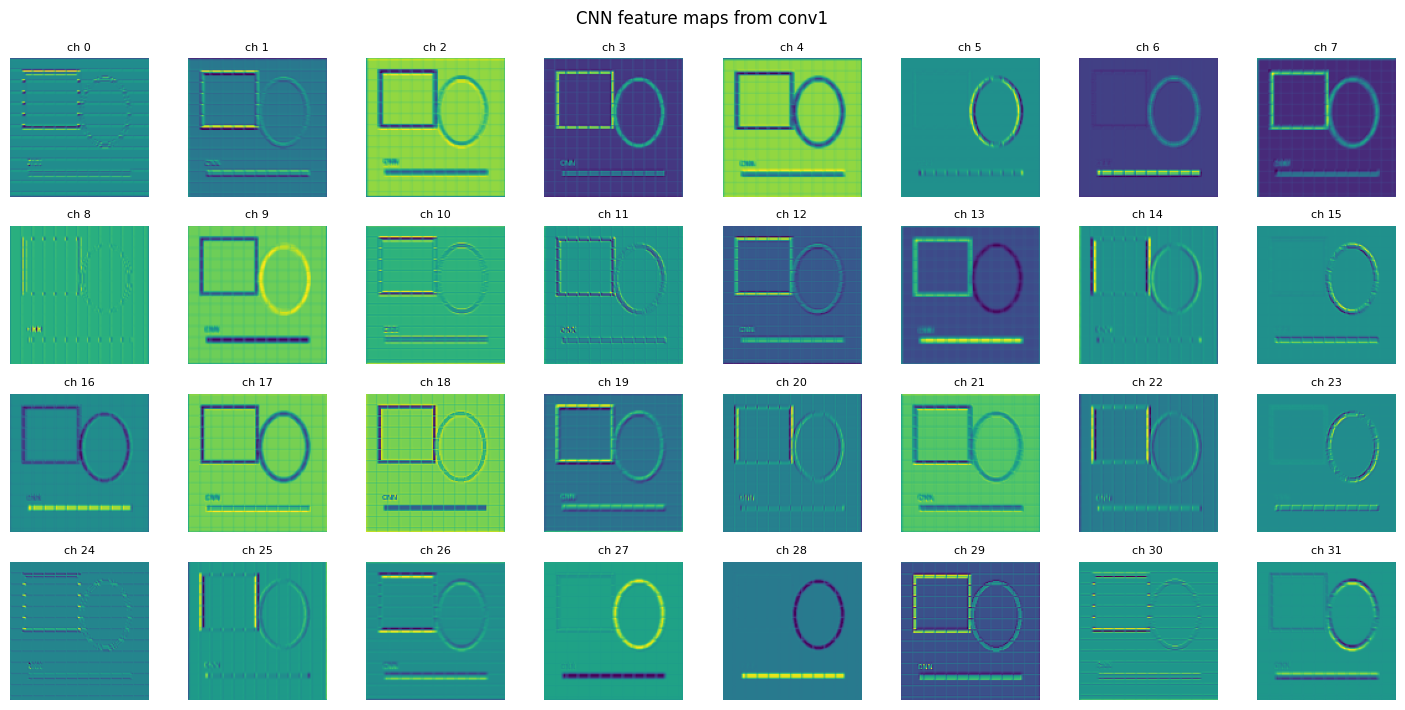

In [28]:
# -------------------------
# Visualization
# -------------------------
def normalize_01(t: torch.Tensor) -> torch.Tensor:
    t = t.clone()
    t -= t.min()
    denom = (t.max() - t.min()).clamp(min=1e-8)
    t /= denom
    return t

# Select first item in batch
feat0 = feat[0]

if MODEL_OUTPUT_KIND == "cnn":
    # feat0: [C, H, W]
    assert feat0.ndim == 3, f"Expected [C,H,W], got {feat0.shape}"
    C, H, W = feat0.shape
    k = min(NUM_FEATURE_MAPS, C)

    ncols = int(N_COLS)
    nrows = int(math.ceil(k / ncols))

    plt.figure(figsize=(1.8*ncols, 1.8*nrows))
    for i in range(k):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(normalize_01(feat0[i]), cmap="viridis")
        plt.axis("off")
        plt.title(f"ch {i}", fontsize=8)
    plt.suptitle(f"CNN feature maps from {LAYER_NAME}")
    plt.tight_layout()
    plt.show()

elif MODEL_OUTPUT_KIND == "vit":
    # feat0: [N, D]
    assert feat0.ndim == 2, f"Expected [N,D], got {feat0.shape}"
    N, D = feat0.shape

    if VIT_HAS_CLS_TOKEN:
        tokens = feat0[1:]
    else:
        tokens = feat0

    Nt = tokens.shape[0]

    if VIT_TOKEN_GRID is None:
        g = int(math.sqrt(Nt))
        assert g * g == Nt, f"Cannot infer grid from {Nt} tokens"
        H = W = g
    else:
        H, W = VIT_TOKEN_GRID
        assert H * W == Nt

    tokens_hw = tokens.view(H, W, D)

    if VIT_SHOW_TOKEN_NORM_MAP:
        norm_map = torch.norm(tokens_hw, dim=-1)
        plt.figure(figsize=(4,4))
        plt.imshow(normalize_01(norm_map), cmap="viridis")
        plt.title("ViT/DINO token L2-norm map")
        plt.axis("off")
        plt.show()

    # Dimension-wise maps
    if VIT_DIM_INDICES is None:
        dims = list(range(min(VIT_NUM_DIMS, D)))
    else:
        dims = VIT_DIM_INDICES

    k = len(dims)
    ncols = int(N_COLS)
    nrows = int(math.ceil(k / ncols))

    plt.figure(figsize=(1.8*ncols, 1.8*nrows))
    for i, d in enumerate(dims):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(normalize_01(tokens_hw[..., d]), cmap="viridis")
        plt.axis("off")
        plt.title(f"dim {d}", fontsize=8)

    plt.suptitle(f"ViT/DINO token maps from {LAYER_NAME}")
    plt.tight_layout()
    plt.show()

else:
    raise ValueError(f"Unknown MODEL_OUTPUT_KIND: {MODEL_OUTPUT_KIND}")
